# Quickstart

This notebook demonstrates how you can find adversarial examples for a pre-trained example network on the MNIST dataset.

We suggest having the `Gurobi` solver installed, since its performance is significantly faster. If this is not possible, the `Cbc` solver is another option.

The `Images` package is only necessary for visualizing the MNIST images.

In [1]:
using MIPVerify
using Gurobi
using Images

## Setup

### MNIST dataset

We begin by loading the MNIST dataset. The data is provided as a Julia `struct` for easy access. The training images and test images are provided as a 4-dimensional array of size `(num_samples, height, width, num_channels)`.

In [2]:
mnist = MIPVerify.read_datasets("MNIST")

mnist:
  `train`: {LabelledImageDataset}
    `images`: 60000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 60000 corresponding labels, with 10 unique labels in [0, 9].
  `test`: {LabelledImageDataset}
    `images`: 10000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 10000 corresponding labels, with 10 unique labels in [0, 9].

In [3]:
mnist.train

{LabelledImageDataset}
    `images`: 60000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 60000 corresponding labels, with 10 unique labels in [0, 9].

In [4]:
size(mnist.train.images)

(60000, 28, 28, 1)

We can use `Images.colorview` to preview these images. 

In [5]:
mnist.train.labels

60000-element Array{UInt8,1}:
 0x05
 0x00
 0x04
 0x01
 0x09
 0x02
 0x01
 0x03
 0x01
 0x04
 0x03
 0x05
 0x03
    ⋮
 0x07
 0x08
 0x09
 0x02
 0x09
 0x05
 0x01
 0x08
 0x03
 0x05
 0x06
 0x08

### Sample Neural Network

We import a sample pre-trained neural network. 

In [6]:
n1 = MIPVerify.get_example_network_params("MNIST.n1")

sequential net MNIST.n1
  (1) Flatten(): flattens 4 dimensional input, with dimensions permuted according to the order [4, 3, 2, 1]
  (2) Linear(784 -> 40)
  (3) ReLU()
  (4) Linear(40 -> 20)
  (5) ReLU()
  (6) Linear(20 -> 10)


`MIPVerify.frac_correct` allows us to verify that the network has a reasonable accuracy on the test set of 96.95%. (This step is crucial when working with your own neural net parameters; since the training is done outside of Julia, a common mistake is to transfer the parameters incorrectly.)

In [7]:
MIPVerify.frac_correct(n1, mnist.test, 10000)

Computing fraction correct...100%|██████████████████████| Time: 0:00:02


0.9695

We feed the first image into the neural net, obtaining the activations of the final softmax layer. 

Note that the image must be specified as a 4-dimensional array with size `(1, height, width, num_channels)`. We provide a helper function `MIPVerify.get_image` that extracts the image from the dataset while preserving all four dimensions.

In [8]:
sample_image = MIPVerify.get_image(mnist.test.images, 1)

1×28×28×1 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

...

[:, :, 26, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 27, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 28, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [9]:
output_activations = sample_image |> n1

10-element Array{Float64,1}:
 -0.0207439
 -0.0174995
  0.167072 
 -0.0532371
 -0.019291 
 -0.0795155
  0.0619113
  4.83397  
  0.46706  
  0.401452 

The category that has the largest activation is category 8, corresponding to a label of 7.

In [10]:
(output_activations |> MIPVerify.get_max_index) - 1

7

This matches the true label.

In [11]:
MIPVerify.get_label(mnist.test.labels, 1)

7

## Finding an Adversarial Example

We now try to find an adversarial example for the first image on `n1`, setting the target category as index `10` (corresponding to a true label of 9).

In [12]:
target_label_index = 10
d = MIPVerify.find_adversarial_example(n1, sample_image, target_label_index, GurobiSolver())

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]


Dict{Any,Any} with 10 entries:
  :PerturbationFamily => unrestricted
  :TargetIndexes      => [10]
  :SolveStatus        => :Optimal
  :TotalTime          => 45.7059
  :TighteningApproach => "loaded_from_cache"
  :Output             => JuMP.GenericAffExpr{Float64,JuMP.Variable}[-0.01206386…
  :PredictedIndex     => 8
  :Model              => Minimization problem with:…
  :Perturbation       => JuMP.Variable[__anon__ __anon__ __anon__ __anon__ __an…
  :PerturbedInput     => JuMP.Variable[__anon__ __anon__ __anon__ __anon__ __an…

[notice | MIPVerify]: Loading model from cache.


In [13]:
using JuMP

perturbed_sample_image = getvalue(d[:PerturbedInput])

Academic license - for non-commercial use only
Optimize a model with 3385 rows, 3256 columns and 71132 nonzeros
Variable types: 3196 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [4e-03, 7e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R1024 by 1.000000000

Presolve removed 2956 rows and 2227 columns
Presolve time: 0.24s
Presolved: 429 rows, 1029 columns, 61365 nonzeros
Variable types: 969 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 223 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    4          -    0.00000      -     -    0s
Another try with MIP start
H    0     0                      36.9304736    0.00000   100%     -    0

1×28×28×1 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

...

[:, :, 26, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 27, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 28, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

As a sanity check, we feed the perturbed image into the neural net and inspect the activation in the final layer. We verify that the perturbed image does maximize the activation of the target label index, which is 10.

In [14]:
perturbed_sample_image |> n1

10-element Array{Float64,1}:
  1.05198 
  0.785344
  0.313807
  0.427011
  0.369729
  0.256145
  0.66623 
  4.56707 
 -0.147984
  4.56707 

We visualize the perturbed image and compare it to the original image. Since we are minimizing the L1-norm, changes are made to only a few pixels, but the magnitude of these changes are large (and noticeable).

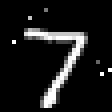

In [15]:
colorview(Gray, perturbed_sample_image[1, :, :, 1])

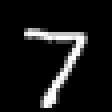

In [16]:
colorview(Gray, sample_image[1, :, :, 1])

That concludes this quickstart! The next tutorial will introduce you to each of the layers, and show how you can import your own neural network parameters.